<a href="https://colab.research.google.com/github/NdiranguMartin/got/blob/master/SAM_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2srtdt68
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2srtdt68
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import glob
import os
import cv2
import nibabel as nib
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as pth_transforms
from PIL import Image
import random
from sklearn.preprocessing import MinMaxScaler #scale values



In [ ]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

Data Preparation

In [ ]:
class BraTS2020Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.patient_folders = sorted(os.listdir(data_dir))
    
    def __len__(self):
        return len(self.patient_folders)
    
    def __getitem__(self, idx):
        patient_folder = self.patient_folders[idx]
        images = []
        for file_name in ['flair', 't1', 't1ce', 't2']:
            file_path = os.path.join(self.data_dir, patient_folder, f'{patient_folder}_{file_name}.nii')
            # print(file_path)
            image = nib.load(file_path).get_fdata()
            images.append(image)
        
        mask_path = os.path.join(self.data_dir, patient_folder, f'{patient_folder}_seg.nii')
        mask = nib.load(mask_path).get_fdata()
        
        if self.transform:
            # Apply transformations to the images and mask
            transformed_images = [self.transform(image) for image in images]
            transformed_mask = self.transform(mask)
            return transformed_images, transformed_mask
        
        return images, mask



In [ ]:
data_dir = '/content/drive/MyDrive/SAM'
train_dir = os.path.join(data_dir,'MICCAI_BraTS2020_TrainingData')
val_dir = os.path.join(data_dir,'MICCAI_BraTS2020_ValidationData')
batch_size = 4
num_epochs = 10

# train_transform = pth_transforms.Compose([
#     pth_transforms.Resize((256, 256)),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

train_transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
])

valid_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = BraTS2020Dataset(train_dir, transform=train_transform)
train_dataloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)


val_dataset = BraTS2020Dataset(val_dir, transform=valid_transform)
val_dataloader = DataLoader(val_dataset,batch_size = batch_size,shuffle = True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize images and masks
def visualize_images(images, masks):
    fig, axes = plt.subplots(len(images), 2, figsize=(10, 10))
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).squeeze().numpy()
        mask = masks[i].squeeze().numpy()

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


  # Data exploration: Visualize example images from the training set
train_samples = next(iter(train_dataloader))
train_images = [sample[0] for sample in train_samples]
train_masks = [sample[1] for sample in train_samples]
visualize_images(train_images, train_masks)


In [ ]:
len(train_sample
    )

NameError: ignored

In [ ]:
from segment_anything.modeling import image_encoder
def visualize_images(images, masks):
    fig, axes = plt.subplots(len(images), 2, figsize=(10, 10))
    for i in range(len(images)):
        image = images[i]
        mask = masks[i].squeeze()

        # If the image has 4 dimensions, remove the first dimension
        if image.dim() == 4:
            image = image.squeeze(0)

        # Convert tensors to numpy arrays
        image = image.numpy()
        mask = mask.numpy()

        # Transpose the image dimensions if necessary
        if image.shape[0] == 1:
            image = np.transpose(image, (1, 2, 0))
            image = image.squeeze().permute(1,2,0)

    

        axes[i, 0].imshow(np.asarray(image_encoder))
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.asarray(mask))
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Data exploration: Visualize example images from the training set
train_samples = next(iter(train_dataloader))
train_images = [sample[0] for sample in train_samples]
train_masks = [sample[1] for sample in train_samples]
# visualize_images(im[0] for im  in train_images)


TypeError: ignored

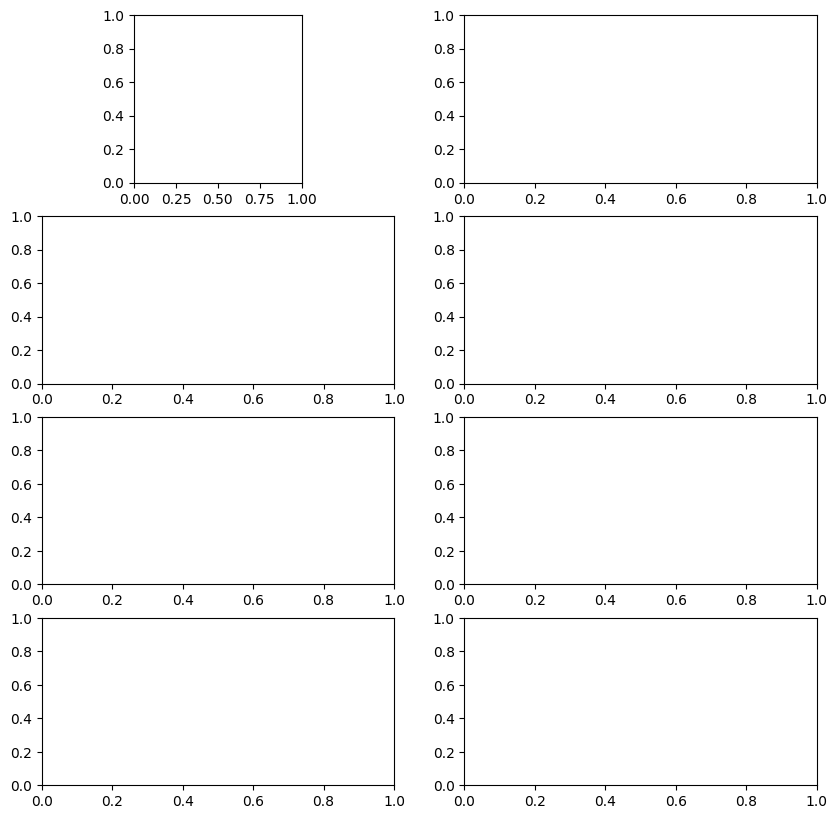

In [ ]:
visualize_images(train_images[0],train_masks[0])



In [ ]:
train_samples = next(iter(train_dataloader))
train_images, train_masks = train_samples[0], train_samples[1]

In [ ]:
sam_checkpoint = "/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
type(val_dataset)

NameError: ignored

In [ ]:
for img in (val_dataset):
    print(f"Processing image {i+1}/{len(image_paths)}: {img_path}")
    # Load the image using OpenCV
    image = cv2.imread(val_dataset)
    # Convert the image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate the masks for the image
    masks = mask_generator.generate(image)

    # Save the masks as png files in a separate directory
    mask_dir = os.path.join(data_dir, "Masks")
    os.makedirs(mask_dir, exist_ok=True)
    mask_file = os.path.join(mask_dir, os.path.splitext(os.path.basename(img_path))[0] + ".png")
    plt.imsave(mask_file, masks[0]["segmentation"])
    

In [ ]:
# Define the SAM model architecture
class SAMModel(nn.Module):
    def __init__(self):
        super(SAMModel, self).__init__()
        # Define your model layers here
        
    def forward(self, x):
        # Define the forward pass of your model
        return x